In [1]:
import polars as pl
import pandas as pd

In [2]:
customer = pl.read_csv("QVI_purchase_behaviour.csv", try_parse_dates=True)

In [3]:
# utf8 error if you use read_csv
# Also need to install fastexcel via conda
transaction = pl.read_excel("QVI_transaction_data.xlsx", schema_overrides={"DATE":pl.Date})

In [4]:
customer

LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER
i64,str,str
1000,"""YOUNG SINGLES/COUPLES""","""Premium"""
1002,"""YOUNG SINGLES/COUPLES""","""Mainstream"""
1003,"""YOUNG FAMILIES""","""Budget"""
1004,"""OLDER SINGLES/COUPLES""","""Mainstream"""
1005,"""MIDAGE SINGLES/COUPLES""","""Mainstream"""
…,…,…
2370651,"""MIDAGE SINGLES/COUPLES""","""Mainstream"""
2370701,"""YOUNG FAMILIES""","""Mainstream"""
2370751,"""YOUNG FAMILIES""","""Premium"""


In [5]:
transaction

DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
date,i64,i64,i64,i64,str,i64,f64
2018-10-17,1,1000,1,5,"""Natural Chip Compny Sea…",2,6.0
2019-05-14,1,1307,348,66,"""CCs Nacho Cheese 175g""",3,6.3
2019-05-20,1,1343,383,61,"""Smiths Crinkle Cut Chips Chic…",2,2.9
2018-08-17,2,2373,974,69,"""Smiths Chip Thinly S/Cream&On…",5,15.0
2018-08-18,2,2426,1038,108,"""Kettle Tortilla ChpsHny&Jlpno …",3,13.8
…,…,…,…,…,…,…,…
2019-03-09,272,272319,270088,89,"""Kettle Sweet Chilli And Sour C…",2,10.8
2018-08-13,272,272358,270154,74,"""Tostitos Splash Of Lime 175g""",1,4.4
2018-11-06,272,272379,270187,51,"""Doritos Mexicana 170g""",2,8.8


### Data Processing

In [6]:
### Remove multiple spaces in PROD_NAME
transaction = transaction.with_columns(
    pl.col("PROD_NAME").str.replace_all(r"\s+", " ")
)

In [7]:
# Remove products that are salsa and not chips
# what does \b mean in regex
chip_keywords = r"(?i)\b(crinkle)" # Since some chips are salsa flavoured we use the or operator to include them (see below)

transaction = transaction.filter(
    ~transaction["PROD_NAME"].str.contains(r"(?i)salsa") |  # Exclude salsa products
    transaction["PROD_NAME"].str.contains(chip_keywords)  # Keep salsa-flavored chips
)

In [8]:
# Get the product weight
transaction = transaction.with_columns(
    transaction["PROD_NAME"]
    .str.extract(r"(?i)(\d+)g")  # Extract numeric value before 'g'
    .cast(pl.Int64)  # Convert the extracted string to an integer
    .alias("weight")  # Rename the new column to "weight"
)

In [9]:
# check for null value
transaction.filter(pl.col("weight").is_null()).select('PROD_NAME').unique()

PROD_NAME
str


In [10]:
transaction

DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,weight
date,i64,i64,i64,i64,str,i64,f64,i64
2018-10-17,1,1000,1,5,"""Natural Chip Compny SeaSalt175…",2,6.0,175
2019-05-14,1,1307,348,66,"""CCs Nacho Cheese 175g""",3,6.3,175
2019-05-20,1,1343,383,61,"""Smiths Crinkle Cut Chips Chick…",2,2.9,170
2018-08-17,2,2373,974,69,"""Smiths Chip Thinly S/Cream&Oni…",5,15.0,175
2018-08-18,2,2426,1038,108,"""Kettle Tortilla ChpsHny&Jlpno …",3,13.8,150
…,…,…,…,…,…,…,…,…
2019-03-09,272,272319,270088,89,"""Kettle Sweet Chilli And Sour C…",2,10.8,175
2018-08-13,272,272358,270154,74,"""Tostitos Splash Of Lime 175g""",1,4.4,175
2018-11-06,272,272379,270187,51,"""Doritos Mexicana 170g""",2,8.8,170


In [ ]:
### Get brand name from PROD_NAME

In [11]:
# We will start by getting unique Product names
unique_products = transaction.select('PROD_NAME').unique()
unique_products.write_csv('unique_products.csv')

In [12]:
# I have edited unique_product.csv to include the brand name
# In addition, I have changed the file name to output.csv

In [11]:
unique_products = pl.read_csv("output.csv", encoding='utf8-lossy')

In [12]:
transaction = transaction.join(unique_products, left_on='PROD_NAME', right_on='PROD_NAME', how='inner')

In [13]:
transaction

DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,weight,mapping
date,i64,i64,i64,i64,str,i64,f64,i64,str
2018-10-17,1,1000,1,5,"""Natural Chip Compny SeaSalt175…",2,6.0,175,"""Natural Chip Company"""
2019-05-14,1,1307,348,66,"""CCs Nacho Cheese 175g""",3,6.3,175,"""Ccs"""
2019-05-20,1,1343,383,61,"""Smiths Crinkle Cut Chips Chick…",2,2.9,170,"""Smiths"""
2018-08-17,2,2373,974,69,"""Smiths Chip Thinly S/Cream&Oni…",5,15.0,175,"""Smiths"""
2018-08-18,2,2426,1038,108,"""Kettle Tortilla ChpsHny&Jlpno …",3,13.8,150,"""Kettle"""
…,…,…,…,…,…,…,…,…,…
2019-03-09,272,272319,270088,89,"""Kettle Sweet Chilli And Sour C…",2,10.8,175,"""Kettle"""
2018-08-13,272,272358,270154,74,"""Tostitos Splash Of Lime 175g""",1,4.4,175,"""Tostitos"""
2018-11-06,272,272379,270187,51,"""Doritos Mexicana 170g""",2,8.8,170,"""Doritos"""


In [14]:
# There are twenty unique brands. The names are listed below.
print(*transaction['mapping'].unique().to_list(), sep='\n')

French Fries
Burger Rings
Natural Chip Company
Doritos
WW
Twisties
Kettle
Cheetos
Sunbites
Smiths
Ccs
Smith
Infuzions
Cheezels
Cobs
Tostitos
RRD
Thins
Pringles
Tyrrells


In [15]:
# All the products have brand names
transaction.filter(pl.col("mapping").is_null()).select('PROD_NAME')

PROD_NAME
str


#### Remove Outlier

In [16]:
# notice max product quantity is 200 which is an outlier. This is likely a business transaction and not a ustomer transaction.
transaction.describe()

statistic,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,weight,mapping
str,str,f64,f64,f64,f64,str,f64,f64,f64,str
"""count""","""248212""",248212.0,248212.0,248212.0,248212.0,"""248212""",248212.0,248212.0,248212.0,"""248212"""
"""null_count""","""0""",0.0,0.0,0.0,0.0,"""0""",0.0,0.0,0.0,"""0"""
"""mean""","""2018-12-30 01:30:20.102000""",135.038455,135516.373113,135117.781848,56.249025,null,1.907869,7.306842,175.433653,null
"""std""",null,76.777578,80683.550528,78136.771877,33.621872,null,0.658467,3.075281,59.290976,null
"""min""","""2018-07-01""",1.0,1000.0,1.0,1.0,"""Burger Rings 220g""",1.0,1.7,70.0,"""Burger Rings"""
"""25%""","""2018-09-30""",70.0,70014.0,67558.0,27.0,null,2.0,5.8,150.0,null
"""50%""","""2018-12-30""",130.0,130360.0,135148.0,52.0,null,2.0,7.4,170.0,null
"""75%""","""2019-03-31""",203.0,203078.0,202628.0,87.0,null,2.0,8.8,175.0,null
"""max""","""2019-06-30""",272.0,2.373711e6,2.415841e6,114.0,"""Woolworths Cheese Rings 190g""",200.0,650.0,380.0,"""WW"""


In [17]:
transaction = transaction.filter(~(transaction["PROD_QTY"] == 200))

In [18]:
# As we can see there are no more outliers
# Furthermore we can see the most common product quantity is 2 and second most common product quantity is 1
# Since the number of people buying 3 or more products is negigble this suggests that discounts should not involve 3 or more products
transaction.group_by('PROD_QTY').len()

PROD_QTY,len
i64,u32
3,412
2,221339
1,25670
4,373
5,416


In [19]:
# There are 8.62 times more people choosing buys products where product quantity is 2 over product 1
221339/25670

8.622477600311647

#### Check for missing date

In [20]:
# Create a complete date range
date_range = pd.date_range(start=transaction['DATE'].min(), end=transaction['DATE'].max()).to_series()

# Convert date_range to polars DataFrame
date_range_df = pl.DataFrame({'DATE': date_range}).cast(pl.Date)

# Find missing dates
missing_dates = date_range_df.join(transaction, on='DATE', how='anti')

In [21]:
# unsuprisingly the date Christmas does not appear to have any sales
missing_dates

DATE
date
2018-12-25


#### Merge transaction with customers

In [24]:
transaction = transaction.join(customer, on='LYLTY_CARD_NBR', how='left')

In [25]:
transaction

DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,weight,mapping,LIFESTAGE,PREMIUM_CUSTOMER
date,i64,i64,i64,i64,str,i64,f64,i64,str,str,str
2018-10-17,1,1000,1,5,"""Natural Chip Compny SeaSalt175…",2,6.0,175,"""Natural Chip Company""","""YOUNG SINGLES/COUPLES""","""Premium"""
2019-05-14,1,1307,348,66,"""CCs Nacho Cheese 175g""",3,6.3,175,"""Ccs""","""MIDAGE SINGLES/COUPLES""","""Budget"""
2019-05-20,1,1343,383,61,"""Smiths Crinkle Cut Chips Chick…",2,2.9,170,"""Smiths""","""MIDAGE SINGLES/COUPLES""","""Budget"""
2018-08-17,2,2373,974,69,"""Smiths Chip Thinly S/Cream&Oni…",5,15.0,175,"""Smiths""","""MIDAGE SINGLES/COUPLES""","""Budget"""
2018-08-18,2,2426,1038,108,"""Kettle Tortilla ChpsHny&Jlpno …",3,13.8,150,"""Kettle""","""MIDAGE SINGLES/COUPLES""","""Budget"""
…,…,…,…,…,…,…,…,…,…,…,…
2019-03-09,272,272319,270088,89,"""Kettle Sweet Chilli And Sour C…",2,10.8,175,"""Kettle""","""YOUNG SINGLES/COUPLES""","""Premium"""
2018-08-13,272,272358,270154,74,"""Tostitos Splash Of Lime 175g""",1,4.4,175,"""Tostitos""","""YOUNG SINGLES/COUPLES""","""Premium"""
2018-11-06,272,272379,270187,51,"""Doritos Mexicana 170g""",2,8.8,170,"""Doritos""","""YOUNG SINGLES/COUPLES""","""Premium"""


In [26]:
transaction.filter(pl.col("LIFESTAGE").is_null() | pl.col("PREMIUM_CUSTOMER").is_null())

DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,weight,mapping,LIFESTAGE,PREMIUM_CUSTOMER
date,i64,i64,i64,i64,str,i64,f64,i64,str,str,str


### Q1. What is the number of purchases for each product.

In [27]:
print(transaction.group_by('PROD_NAME').len().sort(by='len', descending=True).head(10))

shape: (10, 2)
┌─────────────────────────────────┬──────┐
│ PROD_NAME                       ┆ len  │
│ ---                             ┆ ---  │
│ str                             ┆ u32  │
╞═════════════════════════════════╪══════╡
│ Kettle Mozzarella Basil & Pest… ┆ 3304 │
│ Kettle Tortilla ChpsHny&Jlpno … ┆ 3296 │
│ Cobs Popd Swt/Chlli &Sr/Cream … ┆ 3269 │
│ Tyrrells Crisps Ched & Chives … ┆ 3268 │
│ Cobs Popd Sea Salt Chips 110g   ┆ 3265 │
│ Kettle 135g Swt Pot Sea Salt    ┆ 3257 │
│ Tostitos Splash Of Lime 175g    ┆ 3252 │
│ Infuzions Thai SweetChili Pota… ┆ 3242 │
│ Smiths Crnkle Chip Orgnl Big B… ┆ 3233 │
│ Thins Potato Chips Hot & Spicy… ┆ 3229 │
└─────────────────────────────────┴──────┘


In [35]:
#transaction.group_by('PROD_NAME').len().glimpse(max_items_per_column=200)

In [25]:
product_count = transaction.group_by('PROD_NAME').len()

In [37]:
product_count.write_csv('product_count.csv')

In [9]:
# The following code does not work for some reason
"""
temp = product_count['PROD_NAME'].str.contains("(?i)salsa").alias("regex")
product_count.filter(temp['regex'])
"""

'\ntemp = product_count[\'PROD_NAME\'].str.contains("(?i)salsa").alias("regex")\nproduct_count.filter(temp[\'regex\'])\n'

### Q2 What is the number of transactions over time?

In [28]:
import matplotlib.pyplot as plt

In [29]:
num_transactions = (transaction
                    .group_by('DATE')
                    .len()
                    .sort('DATE', descending=False))

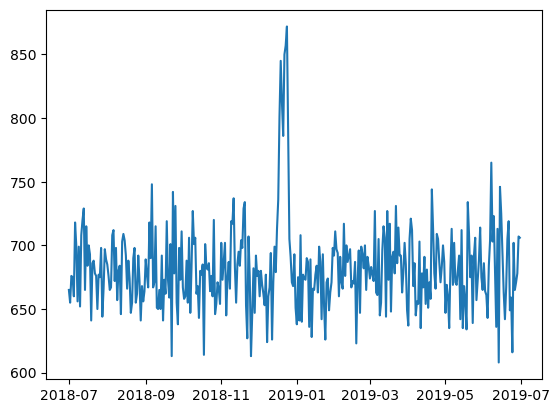

In [30]:
# We can see a massive spike near the end of the year.
# This is likely because of the time being near Christmas or New Year Eve
plt.plot(num_transactions['DATE'], num_transactions['len'])

In [31]:
# We can see from the output the cause is due to 2018-12-18 to 2018-12-24 being lead up to Christmas
num_transactions.filter(num_transactions['len']>750)

DATE,len
date,u32
2018-12-18,801
2018-12-19,845
2018-12-20,812
2018-12-21,786
2018-12-22,850
2018-12-23,857
2018-12-24,872
2019-06-07,765


### Q3 What are the top 10 products over time going by sales?

In [32]:
# We can see that the top performing product is Kettle Original
# What is very interesting in particular us the big jump in sales going from Natural Chip Co to Thins
transaction.group_by('PROD_NAME').sum()[['PROD_NAME', 'TOT_SALES']].head(10).sort('TOT_SALES', descending=True)

PROD_NAME,TOT_SALES
str,f64
"""Kettle Original 175g""",32740.2
"""Kettle Sea Salt And Vinegar 17…",32589.0
"""Twisties Cheese Burger 250g""",26096.7
"""Pringles Sweet&Spcy BBQ 134g""",22477.5
"""Pringles Slt Vingar 134g""",21963.2
"""Thins Chips Salt & Vinegar 175…",19575.6
"""Natural ChipCo Sea Salt & Vine…",8733.0
"""Red Rock Deli Thai Chilli&Lime…",7589.7
"""Cheezels Cheese Box 125g""",5733.0


### Q4 How is product weight distributed?

In [ ]:
# We can see from the bar plot/dataframe below the most preferred product weight is 175g

In [33]:
print(*transaction['weight'].unique().to_list(), sep='\n')

70
90
110
125
134
135
150
160
165
170
175
180
190
200
210
220
250
270
330
380


In [34]:
weight_counts = transaction['weight'].value_counts(sort=True)

In [35]:
weight_counts.head(10)

weight,count
i64,u32
175,66390
150,41673
134,25102
110,22387
170,19983
165,15297
330,12540
380,6416
270,6285


<BarContainer object of 20 artists>

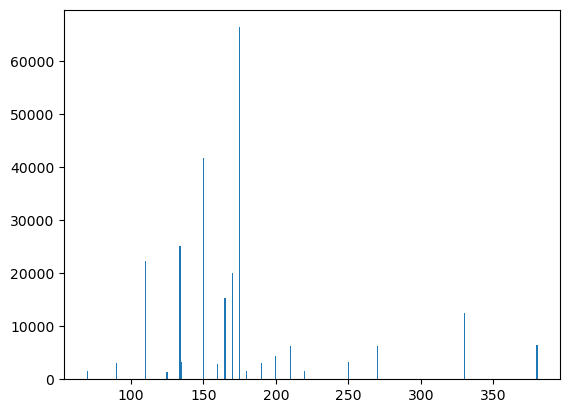

In [36]:
plt.bar(x=weight_counts['weight'], height=weight_counts['count'])

In [57]:
weight_counts.write_csv('weights.csv')

### Q5. How does lifestage affect chip spending?

In [37]:
"""
Going by TOT_SALES the average amount money spent in a transaction in buying chips is about 7.2 dollars
This does not consider average price of a chip packet or the total sum of sales across all dates

Interestingly singles/couples spend more in a single transaction then families with the exception of young singles/couples.
"""
transaction.group_by("LIFESTAGE").mean()[['LIFESTAGE', 'TOT_SALES']]

LIFESTAGE,TOT_SALES
str,f64
"""MIDAGE SINGLES/COUPLES""",7.355373
"""OLDER SINGLES/COUPLES""",7.388932
"""YOUNG FAMILIES""",7.260996
"""OLDER FAMILIES""",7.260064
"""YOUNG SINGLES/COUPLES""",7.162742
"""NEW FAMILIES""",7.273449
"""RETIREES""",7.360632
